In [ ]:

import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

In [ ]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'incepv3_90_10Epoch_65.h5' 

# loading up our datasets
train_data_dir = r'/content/drive/My Drive/New Colab/New_Data/90-10/Training'
validation_data_dir = r'/content/drive/My Drive/New Colab/New_Data/90-10/Validation'
test_data_dir = r'/content/drive/My Drive/New Colab/New_Data/90-10/Testing'

   
# number of epochs to train top model  
epochs = 65 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 100

In [ ]:
#Loading InceptionV3 model
inception = applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files
datagen_2=ImageDataGenerator(rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)


In [ ]:
#Creating weight with InceptionV3
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen_2.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = inception.predict_generator(generator, predict_size_train)  
   
np.save(r'/content/drive/My Drive/New Colab/New_Data/90-10/bottleneck_features_traini.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 832 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
Time:  0:10:49.986795


In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = inception.predict_generator(  
     generator, predict_size_validation)  
   
np.save(r'/content/drive/My Drive/New Colab/New_Data/90-10/bottleneck_features_validationi.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 94 images belonging to 2 classes.
Time:  0:01:05.593691


In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = inception.predict_generator(  
     generator, predict_size_test)  
   
np.save(r'/content/drive/My Drive/New Colab/New_Data/90-10/bottleneck_features_testi.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 104 images belonging to 2 classes.
Time:  0:01:09.937779


In [ ]:
#training data
generator_top = datagen_2.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='binary',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load(r'/content/drive/My Drive/New Colab/New_Data/90-10/bottleneck_features_traini.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 832 images belonging to 2 classes.


In [ ]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load(r'/content/drive/My Drive/New Colab/New_Data/90-10/bottleneck_features_validationi.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 94 images belonging to 2 classes.


In [ ]:
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load(r'/content/drive/My Drive/New Colab/New_Data/90-10/bottleneck_features_testi.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 104 images belonging to 2 classes.


In [ ]:
#Training the model
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
#model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dense(100, activation='relu'))  
model.add(Dropout(0.5))  
#model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dense(100, activation='relu'))  
model.add(Dropout(0.5)) 
model.add(Dense(2, activation='sigmoid'))  

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=65,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/65
9/9 [==============================] - 1s 95ms/step - loss: 0.6958 - acc: 0.6611 - val_loss: 0.4074 - val_acc: 0.8617
Epoch 2/65
9/9 [==============================] - 1s 80ms/step - loss: 0.5033 - acc: 0.8149 - val_loss: 0.3445 - val_acc: 0.8936
Epoch 3/65
9/9 [==============================] - 1s 82ms/step - loss: 0.4569 - acc: 0.8317 - val_loss: 0.3076 - val_acc: 0.8830
Epoch 4/65
9/9 [==============================] - 1s 80ms/step - loss: 0.4217 - acc: 0.8522 - val_loss: 0.2781 - val_acc: 0.8936
Epoch 5/65
9/9 [==============================] - 1s 80ms/step - loss: 0.3754 - acc: 0.8954 - val_loss: 0.2582 - val_acc: 0.8936
Epoch 6/65
9/9 [==============================] - 1s 81ms/step - loss: 0.3787 - acc: 0.8834 - val_loss: 0.2450 - val_acc: 0.8936
Epoch 7/65
9/9 [==============================] - 1s 80ms/step - loss: 0.3601 - acc: 0.8978 - val_loss: 0.2342 - val_acc: 0.9043
Epoch 8/65
9/9 [==============================] - 1s 84ms/step - loss: 0.3401 - acc: 0.8930 - val

In [ ]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               5120100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,130,402
Trainable params: 5,130,402
Non-trainable params: 0
______________________________________________

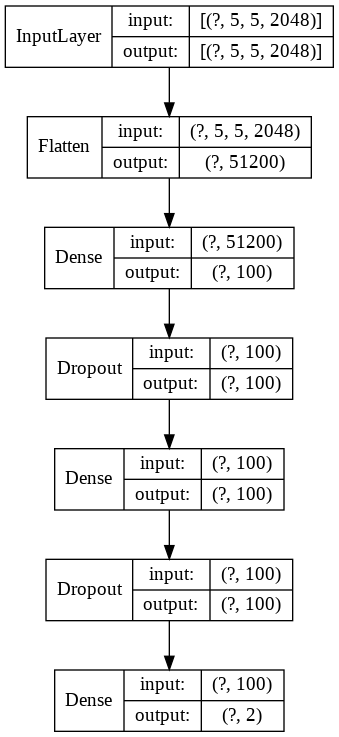

In [ ]:
from tensorflow.keras.utils import  plot_model
plot_model(model, to_file=r'/content/drive/My Drive/New Colab/New_Data/90-10/inception.png', show_shapes=True, show_layer_names=False)


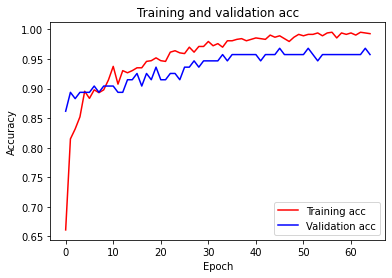

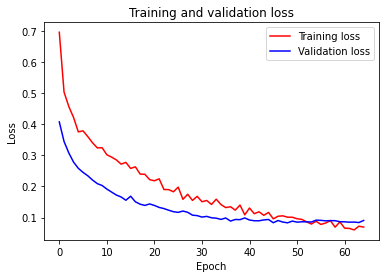

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#Model evaluation on testing set
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 7ms/step - loss: 0.1183 - acc: 0.9808


[0.11825622618198395, 0.9807692170143127]

In [ ]:
#Classification metrics and confussion matrix
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.40485469 0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.8082939  ... 0.         0.
    0.        ]
   [1.0298526  0.37644002 0.61498636 ... 0.         0.
    0.        ]
   [1.1889931  1.0303525  0.6876189  ... 0.         0.
    0.        ]]

  [[0.         0.         0.27688527 ... 0.         0.
    0.        ]
   [0.12745082 0.04024199 0.         ... 0.         0.
    0.        ]
   [0.1021996  0.         1.3039261  ... 0.         0.
    0.        ]
   [0.41154137 0.35414714 1.9253013  ... 0.         0.
    0.        ]
   [0.         0.524667   0.77007693 ... 0.         0.
    0.        ]]

  [[0.19120766 0.         0.         ... 0.         0.
    0.        ]
   [1.6489663  0.         0.00800074 ... 0.         0.
    0.        ]
   [1.8441007  1.1654525  0.5307921  ... 0.         0.
    0.        ]
   [0.66369855 0.54106057 0.8027158  ... 0.31838375 0.
    0.  

In [ ]:
plants = ['Healthy', 'Late_Blight']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=plants )
print(classification_metrics)

              precision    recall  f1-score   support

     Healthy       1.00      0.98      0.99        52
 Late_Blight       0.96      1.00      0.98        52

   micro avg       0.98      0.99      0.99       104
   macro avg       0.98      0.99      0.99       104
weighted avg       0.98      0.99      0.99       104
 samples avg       0.99      0.99      0.99       104



In [ ]:
import pandas as pd
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
#To get better visual of the confusion matrix:
import itertools
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

   

In [ ]:
 plot_confusion_matrix(confusion_matrix, ['Healthy', 'Late_blight'])

In [ ]:
plot_confusion_matrix(confusion_matrix, 
                      ['Healthy', 'Late_Blight'],
                     normalize=True)

In [ ]:
#Testing image on a model

def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [ ]:
def test_single_image(path):
    plants = [ 'Healthy', 'Late_Blight']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = inception.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, plant, x in zip(range(0,2), plants , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, plant, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [ ]:
path1='/content/drive/My Drive/New Colab/New_Data/90-10/Testing/Late_Blight/Late_Blight (112).JPG'
path2='/content/drive/My Drive/New Colab/New_Data/90-10/Testing/Late_Blight/Late_Blight (144).JPG'
path3='/content/drive/My Drive/New Colab/New_Data/90-10/Testing/Healthy/Healthy (102).JPG'
path4='/content/drive/My Drive/New Colab/New_Data/90-10/Testing/Healthy/Healthy (105).JPG'
path5='/content/drive/My Drive/New Colab/New_Data/90-10/Testing/Late_Blight/Late_Blight (7).JPG'
path6='/content/drive/My Drive/New Colab/New_Data/90-10/Testing/Late_Blight/Late_Blight (63).JPG'

[INFO] loading and preprocessing image...
ID: 0, Label: Healthy 9.86%
ID: 1, Label: Late_Blight 90.52%
Final Decision:
.
..
...
ID: 1, Label: Late_Blight


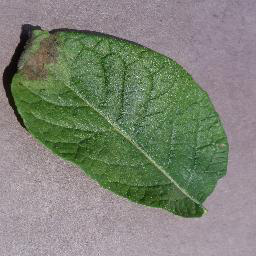

In [ ]:
test_single_image(path1)

[INFO] loading and preprocessing image...
ID: 0, Label: Healthy 1.78%
ID: 1, Label: Late_Blight 98.22%
Final Decision:
.
..
...
ID: 1, Label: Late_Blight


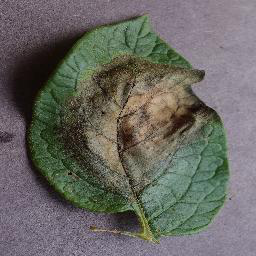

In [ ]:
test_single_image(path2)

[INFO] loading and preprocessing image...
ID: 0, Label: Healthy 90.44%
ID: 1, Label: Late_Blight 15.45%
Final Decision:
.
..
...
ID: 0, Label: Healthy


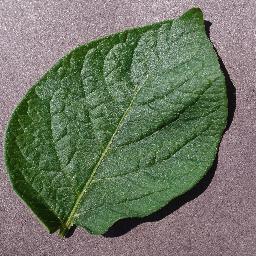

In [ ]:
test_single_image(path3)

[INFO] loading and preprocessing image...
ID: 0, Label: Healthy 49.07%
ID: 1, Label: Late_Blight 46.75%
Final Decision:
.
..
...
ID: 0, Label: Healthy


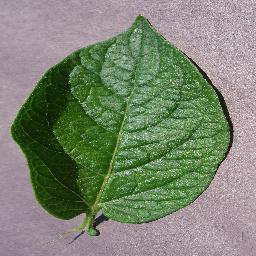

In [ ]:
test_single_image(path4)

[INFO] loading and preprocessing image...
ID: 0, Label: Healthy 8.11%
ID: 1, Label: Late_Blight 88.66%
Final Decision:
.
..
...
ID: 1, Label: Late_Blight


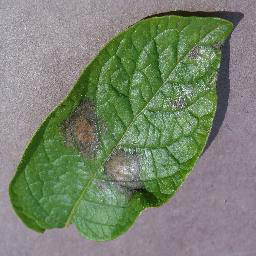

In [ ]:
test_single_image(path5)

[INFO] loading and preprocessing image...
ID: 0, Label: Healthy 8.87%
ID: 1, Label: Late_Blight 91.36%
Final Decision:
.
..
...
ID: 1, Label: Late_Blight


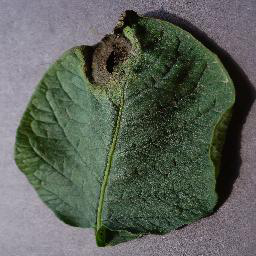

In [ ]:
test_single_image(path6)

In [ ]:
print("Evaluation")
print("Training loss and accuracy\n")
model.evaluate(train_data, train_labels)
print("Validation loss and accuray\n")
model.evaluate(validation_data, validation_labels)
print("Testing loss and accuary\n")
model.evaluate(test_data, test_labels)

Evaluation
Training loss and accuracy

26/26 [==============================] - 0s 12ms/step - loss: 0.0087 - acc: 1.0000
Validation loss and accuray

3/3 [==============================] - 0s 8ms/step - loss: 0.0906 - acc: 0.9574
Testing loss and accuary

4/4 [==============================] - 0s 7ms/step - loss: 0.1183 - acc: 0.9808


[0.11825622618198395, 0.9807692170143127]